<a href="https://colab.research.google.com/github/Alfonso-Jesus-Garcia-Moya/Proyecto_Final_de_PREDICCI-N-ESTRUCTURADA-ESTAD-STICA/blob/main/Proyecto_Final_de_PREDICCI_N_ESTRUCTURADA_ESTAD_STICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- DATOS GENERADOS ---
Total muestras: 2000, Train: 1600, Test: 400

--- ENTRENANDO MODELO 1: HMM ---
--- ENTRENANDO MODELO 2: LOGISTIC REGRESSION ---
--- ENTRENANDO MODELO 3: CRF ---

RESULTADOS FINALES (Accuracy):
HMM (Generativo): 0.9475
CRF (Estructurado): 0.8275
LogReg (Baseline): 0.6800


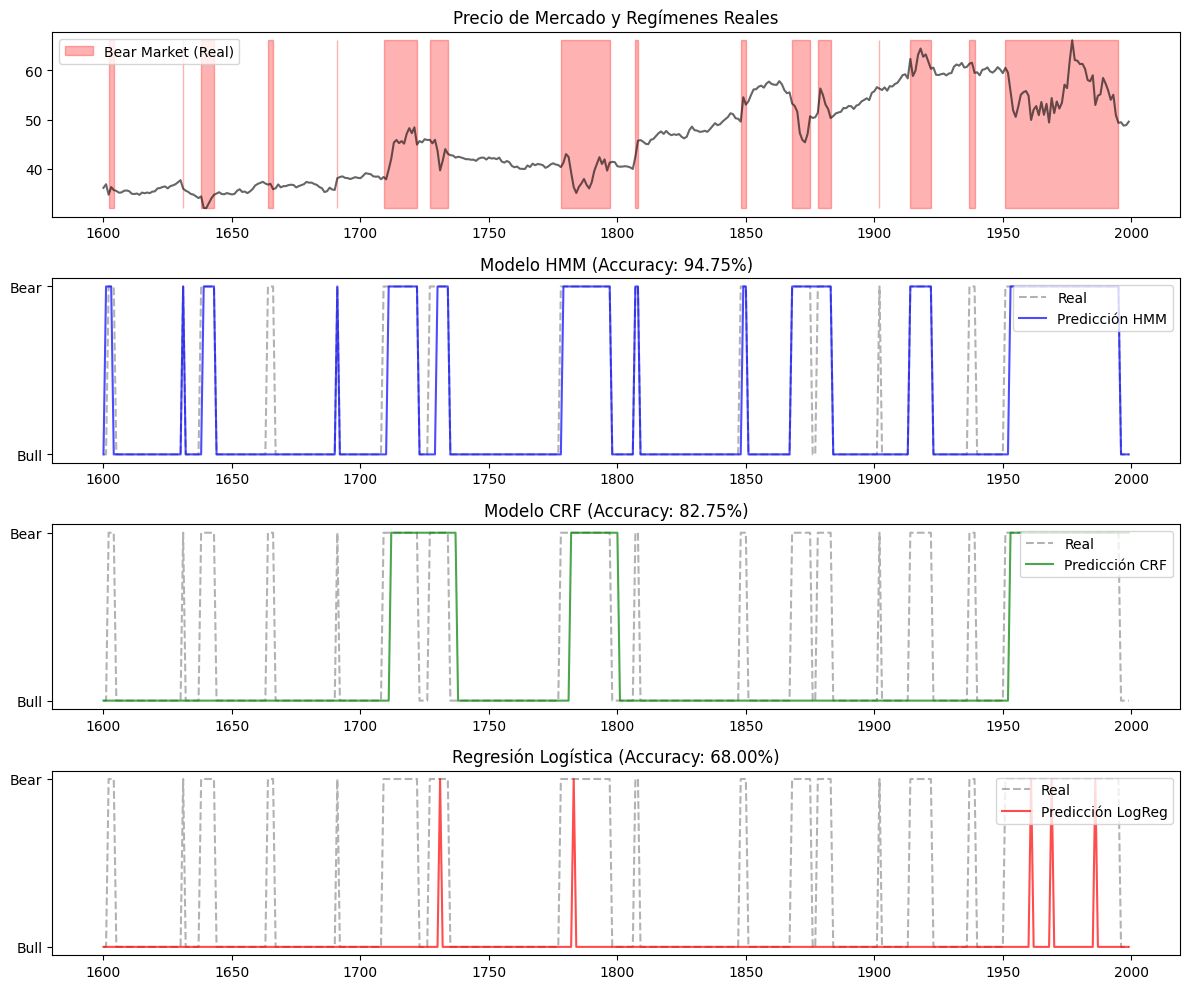

In [2]:
# --- BLOQUE CORREGIDO FINAL ---
!pip install hmmlearn sklearn-crfsuite -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
import sklearn_crfsuite
from sklearn_crfsuite import metrics as crf_metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import warnings

# Ignorar warnings de convergencia para que salga limpio
warnings.filterwarnings("ignore")

# 1. SIMULACIÓN DE DATOS QUANT (Market Regime)
np.random.seed(42)
n_samples = 2000

# Estado 0: Bull (Drift positivo, baja volatilidad)
# Estado 1: Bear (Drift negativo, alta volatilidad)
true_states = np.zeros(n_samples)
returns = np.zeros(n_samples)
state = 0
# Matriz de transición: Probabilidad de quedarse en el estado es alta
trans_matrix = [[0.95, 0.05], [0.10, 0.90]]
params = {0: {'mu': 0.001, 'sigma': 0.01}, 1: {'mu': -0.002, 'sigma': 0.04}}

for t in range(1, n_samples):
    p = trans_matrix[int(state)]
    state = np.random.choice([0, 1], p=p)
    true_states[t] = state
    returns[t] = np.random.normal(params[state]['mu'], params[state]['sigma'])

df = pd.DataFrame({'Returns': returns, 'State': true_states})
df['Price'] = 100 * (1 + df['Returns']).cumprod()

# Feature Engineering
# Calculamos esto ANTES del split para tener la historia completa
df['Ret_Lag1'] = df['Returns'].shift(1).fillna(0)
df['Vol_5d'] = df['Returns'].rolling(5).std().fillna(0)
df['Ret_Abs'] = np.abs(df['Returns'])

# Split Train/Test
split = int(n_samples * 0.8)
train_data = df.iloc[:split]
test_data = df.iloc[split:]

print("--- DATOS GENERADOS ---")
print(f"Total muestras: {n_samples}, Train: {len(train_data)}, Test: {len(test_data)}")

# --- MODELO 1: HMM (Generativo) ---
print("\n--- ENTRENANDO MODELO 1: HMM ---")
# Aumentamos n_iter y tol para evitar el warning de no convergencia
hmm = GaussianHMM(n_components=2, covariance_type="diag", n_iter=200, tol=0.01, random_state=42)
hmm.fit(train_data['Returns'].values.reshape(-1, 1))
hmm_states = hmm.predict(test_data['Returns'].values.reshape(-1, 1))

# Alineación de estados (Si el HMM aprendió al revés, lo invertimos)
if np.corrcoef(hmm_states, test_data['State'])[0, 1] < 0:
    hmm_states = 1 - hmm_states

# --- MODELO 2: LOGISTIC REGRESSION (Baseline) ---
print("--- ENTRENANDO MODELO 2: LOGISTIC REGRESSION ---")
X_cols = ['Returns', 'Ret_Lag1', 'Vol_5d', 'Ret_Abs']
lr = LogisticRegression()
lr.fit(train_data[X_cols], train_data['State'])
lr_pred = lr.predict(test_data[X_cols])

# --- MODELO 3: CRF (Estructurado) ---
print("--- ENTRENANDO MODELO 3: CRF ---")

# FUNCIÓN CORREGIDA: Usamos 'Ret_Lag1' directo en lugar de iloc manual
def df_to_crf_seq(df_in):
    sent_features = []
    sent_labels = []
    for i, row in df_in.iterrows():
        feat = {
            'return': row['Returns'],
            'vol_5d': row['Vol_5d'],
            'bias': 1.0,
            'prev_return': row['Ret_Lag1'] # CORRECCIÓN: Usar la columna pre-calculada
        }
        sent_features.append(feat)
        sent_labels.append(str(int(row['State'])))
    return [sent_features], [sent_labels]

X_train_crf, y_train_crf = df_to_crf_seq(train_data)
X_test_crf, y_test_crf = df_to_crf_seq(test_data)

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train_crf, y_train_crf)
crf_pred_seq = crf.predict(X_test_crf)[0]
crf_pred = np.array([int(x) for x in crf_pred_seq])

# --- RESULTADOS Y GRÁFICOS ---
y_true = test_data['State'].values

acc_hmm = accuracy_score(y_true, hmm_states)
acc_lr = accuracy_score(y_true, lr_pred)
acc_crf = accuracy_score(y_true, crf_pred)

print(f"\nRESULTADOS FINALES (Accuracy):")
print(f"HMM (Generativo): {acc_hmm:.4f}")
print(f"CRF (Estructurado): {acc_crf:.4f}")
print(f"LogReg (Baseline): {acc_lr:.4f}")

# Gráficos Profesionales
plt.figure(figsize=(12, 10))

# 1. Realidad
plt.subplot(4, 1, 1)
plt.plot(test_data.index, test_data['Price'], color='black', alpha=0.6)
plt.fill_between(test_data.index, test_data['Price'].min(), test_data['Price'].max(),
                 where=test_data['State']==1, color='red', alpha=0.3, label='Bear Market (Real)')
plt.title('Precio de Mercado y Regímenes Reales')
plt.legend(loc='upper left')

# 2. HMM
plt.subplot(4, 1, 2)
plt.plot(test_data.index, test_data['State'], 'k--', alpha=0.3, label='Real')
plt.plot(test_data.index, hmm_states, 'b-', alpha=0.7, label='Predicción HMM')
plt.title(f'Modelo HMM (Accuracy: {acc_hmm:.2%})')
plt.yticks([0, 1], ['Bull', 'Bear'])
plt.legend(loc='upper right')

# 3. CRF
plt.subplot(4, 1, 3)
plt.plot(test_data.index, test_data['State'], 'k--', alpha=0.3, label='Real')
plt.plot(test_data.index, crf_pred, 'g-', alpha=0.7, label='Predicción CRF')
plt.title(f'Modelo CRF (Accuracy: {acc_crf:.2%})')
plt.yticks([0, 1], ['Bull', 'Bear'])
plt.legend(loc='upper right')

# 4. LogReg
plt.subplot(4, 1, 4)
plt.plot(test_data.index, test_data['State'], 'k--', alpha=0.3, label='Real')
plt.plot(test_data.index, lr_pred, 'r-', alpha=0.7, label='Predicción LogReg')
plt.title(f'Regresión Logística (Accuracy: {acc_lr:.2%})')
plt.yticks([0, 1], ['Bull', 'Bear'])
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()